# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug torch torchvision tqdm

In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
import os

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [3]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-01-12 13:14:46--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.144
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  48.0MB/s    in 23s     

2022-01-12 13:15:10 (46.8 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [4]:
%%capture
!aws s3 cp dogImages s3://image-classification-3/ --recursive

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [8]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [9]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='image_pytorch_hpo',
    role=role,
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py36'
)# TODO: Your estimator here

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type,
    early_stopping_type="Auto",
)# TODO: Your HP tuner here

In [10]:
# TODO: Fit your HP Tuner
# os.environ['SM_CHANNEL_TRAINING']='s3://image-classification-3/'
# os.environ['SM_MODEL_DIR']='s3://image-classification-3/model/'
# os.environ['SM_OUTPUT_DATA_DIR']='s3://image-classification-3/output/'
tuner.fit({"training": "s3://image-classification-3/"}, wait=True) # TODO: Remember to include your data channels

.................................................................................................................................................................................................................................................................................................................................................................!


In [11]:
# TODO: Get the best estimators and the best HPs
best_estimator=tuner.best_estimator()

# Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-01-12 13:55:25 Starting - Preparing the instances for training
2022-01-12 13:55:25 Downloading - Downloading input data
2022-01-12 13:55:25 Training - Training image download completed. Training in progress.
2022-01-12 13:55:25 Uploading - Uploading generated training model
2022-01-12 13:55:25 Completed - Training job completed


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'learning_rate': '0.005222375403517124',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"image_pytorch_hpo-2022-01-12-13-31-48-993"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-589233742107/image_pytorch_hpo-2022-01-12-13-31-48-993/source/sourcedir.tar.gz"'}

In [15]:
hyperparameters = {
    "batch_size": int(best_estimator.hyperparameters()["batch_size"].replace('"', "")),
    "learning_rate": best_estimator.hyperparameters()["learning_rate"],
}

In [16]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [17]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "100",
        "eval.save_interval": "10"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.



In [20]:
# TODO: Set up debugging and profiling rules and hooks
estimator = PyTorch(
    entry_point='train_model.py',
    base_job_name='image-pytorch-training',
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.xlarge',
    framework_version='1.8',
    py_version='py36',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [21]:
# TODO: Create and fit an estimator

estimator.fit({"training": "s3://image-classification-3/"}, wait=True)

2022-01-12 14:27:41 Starting - Starting the training job...
2022-01-12 14:28:04 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-01-12 14:29:05 Starting - Preparing the instances for training......
2022-01-12 14:30:05 Downloading - Downloading input data.........
2022-01-12 14:31:38 Training - Downloading the training image...........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-12 14:33:23,897 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-12 14:33:23,916 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-12 14:33:25,331 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-01-12 14:33:25,813 sagemaker-training-toolkit INFO     Invoking user scri

In [22]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [39]:
# Plot a debugging output.
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: image-pytorch-training-2022-01-12-14-27-41-087
Region: us-east-1


In [40]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-589233742107/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-589233742107/image-pytorch-training-2022-01-12-14-27-41-087/profiler-output


Profiler data from system is available


In [41]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2022-01-12 15:45:58.685 ip-172-16-106-178:19902 INFO metrics_reader_base.py:134] Getting 15 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUMemoryUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1'}


**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

In [42]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [43]:
! aws s3 ls {rule_output_path} --recursive

2022-01-12 14:43:54     437177 image-pytorch-training-2022-01-12-14-27-41-087/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-01-12 14:43:53     295931 image-pytorch-training-2022-01-12-14-27-41-087/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-01-12 14:43:49        555 image-pytorch-training-2022-01-12-14-27-41-087/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-01-12 14:43:49      25309 image-pytorch-training-2022-01-12-14-27-41-087/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-01-12 14:43:49       1955 image-pytorch-training-2022-01-12-14-27-41-087/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-01-12 14:43:49        327 image-pytorch-training-2022-01-12-14-27-41-087/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-01-12 14:43:49       4788 image-pytorch-training-2022-01-12-14-27-41-087/rule-output/

In [44]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-589233742107/image-pytorch-training-2022-01-12-14-27-41-087/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-589233742107/image-pytorch-training-2022-01-12-14-27-41-087/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-589233742107/image-pytorch-training-2022-01-12-14-27-41-087/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-589233742107/image-pytorch-training-2022-01-12-14-27-41-087/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download

In [45]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [46]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [47]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy(initial_instance_count=1, instance_type='ml.m5.large') # TODO: Add your deployment configuration like instance type and number of instances

-------!

In [48]:
from sagemaker.pytorch import PyTorchModel

In [49]:
model_data = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"
print(f"Model: {model_data}")

Model: s3://sagemaker-us-east-1-589233742107/image-pytorch-training-2022-01-12-14-27-41-087/output/model.tar.gz


In [50]:
# Implemented the inference.py file which loads and invokes the trained model above.
pytorch_model = PyTorchModel(
    model_data=model_data, 
    role=role, 
    entry_point='inference.py',
    py_version="py36",
    framework_version="1.8"
)
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

-----------!

In [57]:
# TODO: Run a prediction on the endpoint
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# This predict function takes an image, preprocesses it, and uses the endpoint for prediction
def predict(image_object):
    image = Image.open(image_object)

    transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])

    preprocessed_image = transform(image).unsqueeze(0)
    preprocessed_image = preprocessed_image.to("cpu")

    response = predictor.predict(preprocessed_image)
    pred = np.argmax(response, 1)+1
    plt.imshow(Image.open(image_object))
    plt.show()
    print(f"Actual: {int(image_object[17:20])}, Prediction: {pred[0]}")

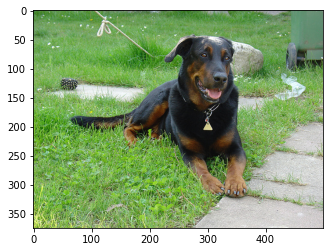

Actual: 18, Prediction: 129



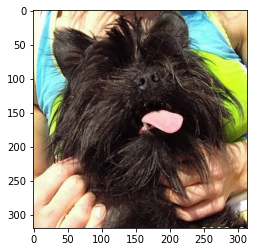

Actual: 1, Prediction: 129



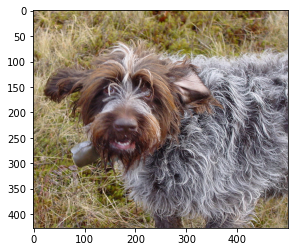

Actual: 131, Prediction: 129



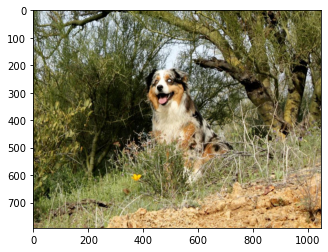

Actual: 12, Prediction: 118



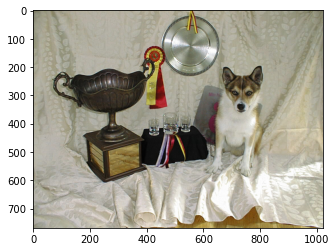

Actual: 110, Prediction: 118



In [58]:
# Images for testing
image_objects = ["./dogImages/test/018.Beauceron/Beauceron_01284.jpg", "./dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg", 
               "./dogImages/test/131.Wirehaired_pointing_griffon/Wirehaired_pointing_griffon_08245.jpg", 
               "./dogImages/test/012.Australian_shepherd/Australian_shepherd_00830.jpg", "./dogImages/test/110.Norwegian_lundehund/Norwegian_lundehund_07222.jpg"]

for path in image_objects:
    predict(path)
    print()

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()